# Download and Prep Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from operator import itemgetter
sns.set()

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


from sklearn import tree
from sklearn.tree import _tree

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 

from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.tree import plot_tree    # late add plot tree

from sklearn.model_selection import GridSearchCV      # sklearn.model_selection.GridSearchCV

from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import confusion_matrix # to create a confusion matrix
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

INFILE = "C:\\Users\\richd\\data\\HMEQ_Loss.csv"

TARGET_F = "TARGET_BAD_FLAG"                         # whether or not the Home Equity Loan defaulted
TARGET_A = "TARGET_LOSS_AMT"                         # amount of money lost for loans that went bad

df = pd.read_csv(INFILE)

dt = df.dtypes

objList = []
numList = []

for i in dt.index :
    if i in ( [ TARGET_F, TARGET_A ] ) : continue       # if target info, move on
    if dt[i] in (["object"]) : objList.append( i )
    if dt[i] in (["float64", "int64"]) : numList.append( i )

## Missing Imputation

In [2]:
# CATEGORICAL IMPUTATION
# Fill in missing with "Missing"

df['IMP_REASON'] = df['REASON']    # create IMP_REASON column
df['IMP_REASON'] = df['IMP_REASON'].fillna("DebtCon")    # replace missing with "DebtCon"

df['IMP_JOB'] = df['JOB']    # create IMP_JOB column
df['IMP_JOB'] = df['IMP_JOB'].fillna("MISSING")      # replace missing jobs with "MISSING"

df = df.drop(['REASON', 'JOB'], axis=1)

objList.append('IMP_REASON')
objList.append('IMP_JOB')
objList.remove('REASON')
objList.remove( 'JOB')

# hot encode/dummies

y = pd.get_dummies(df['IMP_REASON'], prefix="z_", drop_first=True)       # result is homeimpr/missing (if both 0 than debtcon)
y_2 = pd.get_dummies(df['IMP_JOB'], prefix="z_", dummy_na=False)         # result is 0/1 for each of the 6 columns
df = pd.concat([df, y, y_2], axis=1)
df = df.drop(['IMP_REASON', 'IMP_JOB'], axis=1)


# NUMERICAL IMPUTATION
# Create mortdue at 72% of value

mort_perc_of_val = 0.72

# MORTDUE
df['M_MORTDUE'] = df['MORTDUE'].isna() + 0               # creates the missing flag
df['IMP_MORTDUE'] = df['MORTDUE']

df['IMP_MORTDUE'] = df['IMP_MORTDUE'].fillna(df['VALUE'] * mort_perc_of_val)             # set MORTDUE at 70% VALUE
df['IMP_MORTDUE'] = df['IMP_MORTDUE'].fillna(df['IMP_MORTDUE'].median())    # if VALUE null, set MORTDUE to median


# VALUE
df['M_VALUE'] = df['VALUE'].isna() + 0                   # creates the missing flag
df['IMP_VALUE'] = df['VALUE']

df['IMP_VALUE'] = df['IMP_VALUE'].fillna(df['MORTDUE'] * mort_perc_of_val)             # set VALUE so MORTDUE is 72% of VALUE
df['IMP_VALUE'] = df['IMP_VALUE'].fillna(df['IMP_VALUE'].median())           # if VALUE null, set VALUE to median

# drop MORTDUE and VALUE from df and numList
df = df.drop(['MORTDUE', 'VALUE'], axis=1)
numList.remove('MORTDUE')
numList.remove('VALUE')


# fill in mode as missing values for Derog, Delinq, and Ninq

fill_as_mode = ['DEROG', 'DELINQ', 'NINQ']

for i in fill_as_mode :
    if df[i].isna().sum() == 0 : continue    # are any values missing? If no, move along
    FLAG = "M_" + i                          # M_ is  "I fixed missing and this is it"
    IMP = "IMP_" + i                         # IMP_    imputed value
    df[ FLAG ] = df[i].isna() + 0              # creates 1/0 missing flag
    df[ IMP ] = df[i]
    df.loc[ df[IMP].isna(), IMP ] = df[i].mode()[0]        # replaces with mode
    df = df.drop(i, axis=1)                                # drop the extra 
    

# fill in median as missing values for Clage, Clino, Debtinc

fill_as_median = ['YOJ', 'CLAGE', 'CLNO', 'DEBTINC']

for i in fill_as_median :
    if df[i].isna().sum() == 0 : continue    # are any values missing? If no, move along
    FLAG = "M_" + i                          # M_ is  "I fixed missing and this is it"
    IMP = "IMP_" + i                         # IMP_    imputed value
    df[ FLAG ] = df[i].isna() + 0              # creates 1/0 missing flag
    df[ IMP ] = df[i]
    df.loc[ df[IMP].isna(), IMP ] = df[i].median()         # replaces with median
    df = df.drop(i, axis=1)                                # drop the extra 

In [4]:
print(df.head())
print(objList)

   TARGET_BAD_FLAG  TARGET_LOSS_AMT  LOAN  z__HomeImp  z__MISSING  z__Mgr  \
0                1            641.0  1100           1           0       0   
1                1           1109.0  1300           1           0       0   
2                1            767.0  1500           1           0       0   
3                1           1425.0  1500           0           1       0   
4                0              NaN  1700           1           0       0   

   z__Office  z__Other  z__ProfExe  z__Sales  z__Self  M_MORTDUE  IMP_MORTDUE  \
0          0         1           0         0        0          0      25860.0   
1          0         1           0         0        0          0      70053.0   
2          0         1           0         0        0          0      13500.0   
3          0         0           0         0        0          1      62754.0   
4          1         0           0         0        0          0      97800.0   

   M_VALUE  IMP_VALUE  M_DEROG  IMP_DEROG  M_DELIN

## Split Data

In [44]:
X = df.copy()
X = X.drop( TARGET_F, axis=1)
X = X.drop( TARGET_A, axis=1)

Y = df[ [TARGET_F, TARGET_A]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size = 0.2, random_state=1)

print(X_train.shape)
print(X_test.shape)

F = ~ Y_train[ TARGET_A ].isna()
W_train = X_train[F].copy()
Z_train = Y_train[F].copy()

F = ~ Y_test[ TARGET_A ].isna()
W_test = X_test[F].copy()
Z_test = Y_test[F].copy()

(4768, 27)
(1192, 27)


In [45]:
# equation for decision tree variable selection
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

# equation for random forest variable selection
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

## Decision Tree
### Decision Tree Predict Probability of Loan Default

In [46]:
# Model 
fm01_Tree = tree.DecisionTreeClassifier( max_depth=4, random_state=1)
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_F ])

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("\n=============\n")
print("DECISION TREE\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
print("\n")



DECISION TREE

Probability of default
Accuracy Train: 0.8928271812080537
Accuracy Test: 0.8875838926174496




***
A max_depth of 4 is used after experimenting with different numbers from 2-8. At this level of max_depth, the test accuracy plateaued, and it didn't seem to make sense to add more decision nodes without really improving the accuracy.
***

In [47]:
probs = fm01_Tree.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_Tree.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

In [48]:
fpr_tree = fpr_test
tpr_tree = tpr_test
auc_tree = roc_auc_test

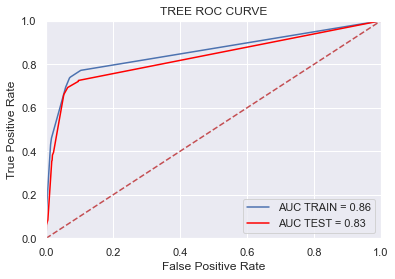

In [49]:
# Plot ROC Curve

plt.title('TREE ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label='AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b',label = 'AUC TEST = %0.2f' % roc_auc_test, color = "red")
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [50]:
# variable selection
feature_cols = list(X.columns.values)
dt_vars_default_prob = getTreeVars(fm01_Tree, feature_cols)
print(dt_vars_default_prob)

# Graph Viz creation
tree.export_graphviz(fm01_Tree, out_file='tree_f.txt', filled=True, rounded=True, feature_names = feature_cols, impurity=False,
                    class_names=["Good", "Bad"])

['z__Mgr', 'M_VALUE', 'M_DEROG', 'IMP_DEROG', 'IMP_DELINQ', 'IMP_YOJ', 'IMP_CLAGE', 'M_DEBTINC', 'IMP_DEBTINC']


[Text(418.5, 366.93, 'X[25] <= 0.5\ngini = 0.317\nsamples = 4768\nvalue = [3827, 941]'),
 Text(209.25, 285.39, 'X[26] <= 44.671\ngini = 0.153\nsamples = 3747\nvalue = [3434, 313]'),
 Text(104.625, 203.85000000000002, 'X[16] <= 4.5\ngini = 0.124\nsamples = 3673\nvalue = [3430, 243]'),
 Text(52.3125, 122.31, 'X[11] <= 0.5\ngini = 0.117\nsamples = 3654\nvalue = [3426, 228]'),
 Text(26.15625, 40.77000000000004, 'gini = 0.111\nsamples = 3635\nvalue = [3421, 214]'),
 Text(78.46875, 40.77000000000004, 'gini = 0.388\nsamples = 19\nvalue = [5, 14]'),
 Text(156.9375, 122.31, 'X[13] <= 0.5\ngini = 0.332\nsamples = 19\nvalue = [4, 15]'),
 Text(130.78125, 40.77000000000004, 'gini = 0.0\nsamples = 15\nvalue = [0, 15]'),
 Text(183.09375, 40.77000000000004, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(313.875, 203.85000000000002, 'X[22] <= 299.897\ngini = 0.102\nsamples = 74\nvalue = [4, 70]'),
 Text(261.5625, 122.31, 'X[22] <= 234.724\ngini = 0.028\nsamples = 70\nvalue = [1, 69]'),
 Text(235.406

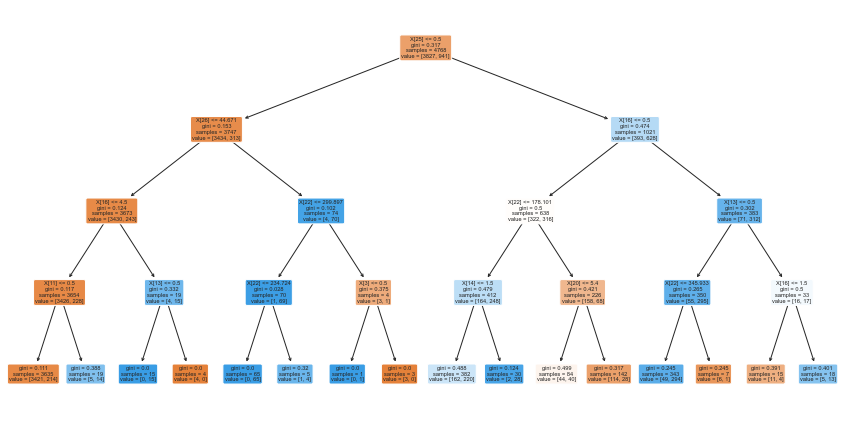

In [51]:
plt.figure(figsize=(15,7.5))
plot_tree(fm01_Tree, filled=True,
         rounded=True)

***
The decision tree does seem to make sense. It appears the 'DEBTINC' info is a powerful indicator of the loan defaulting. I assume if the data is missing, it indicates a lack of information on the individual. If this data is missing, about 62% of the time the loan defaults, whereas available 'DEBTINC' data leads to default less than 10% of the time. From there, missing data on derogatory marks and a low age of credit line seems to be very strong indicators the loan will default.  
***

### Decision Tree Predict Loan Default Loss Amount

In [52]:
# Regression Tree
amt_m01_Tree = tree.DecisionTreeRegressor( max_depth = 4) 
amt_m01_Tree = amt_m01_Tree.fit(W_train, Z_train[TARGET_A])

# Predict if loan defaults
Z_Pred_train = amt_m01_Tree.predict(W_train)
Z_Pred_test = amt_m01_Tree.predict(W_test)

print("MEAN Train", Z_train[TARGET_A].mean())
print("MEAN Test", Z_test[TARGET_A].mean())

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_A], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_A], Z_Pred_test))

print("TREE RMSE Train:", RMSE_TRAIN)
print("TREE RMSE Test:", RMSE_TEST)

RMSE_TREE = RMSE_TEST

MEAN Train 13421.64505844846
MEAN Test 13387.758064516129
TREE RMSE Train: 4610.812636798938
TREE RMSE Test: 5640.984056419067


In [53]:
# Variable Selection
dt_vars_loss_amt = getTreeVars(amt_m01_Tree, feature_cols)

# Graph Viz creation
tree.export_graphviz(amt_m01_Tree, out_file='tree_a.txt', filled=True, rounded=True, feature_names = feature_cols, impurity=False,
                    class_names=["Good", "Bad"])

print(dt_vars_loss_amt)

['LOAN', 'IMP_MORTDUE', 'IMP_CLNO', 'M_DEBTINC', 'IMP_DEBTINC']


[Text(418.5, 366.93, 'X[0] <= 22950.0\nmse = 113567693.513\nsamples = 941\nvalue = 13421.645'),
 Text(209.25, 285.39, 'X[0] <= 11250.0\nmse = 31682619.18\nsamples = 728\nvalue = 9526.135'),
 Text(104.625, 203.85000000000002, 'X[0] <= 6750.0\nmse = 8416805.316\nsamples = 336\nvalue = 5450.393'),
 Text(52.3125, 122.31, 'X[0] <= 4300.0\nmse = 2882312.617\nsamples = 139\nvalue = 3306.194'),
 Text(26.15625, 40.77000000000004, 'mse = 1059603.131\nsamples = 59\nvalue = 2072.475'),
 Text(78.46875, 40.77000000000004, 'mse = 2276178.259\nsamples = 80\nvalue = 4216.062'),
 Text(156.9375, 122.31, 'X[25] <= 0.5\nmse = 6788968.425\nsamples = 197\nvalue = 6963.305'),
 Text(130.78125, 40.77000000000004, 'mse = 5609610.502\nsamples = 55\nvalue = 5004.455'),
 Text(183.09375, 40.77000000000004, 'mse = 5183923.704\nsamples = 142\nvalue = 7722.014'),
 Text(313.875, 203.85000000000002, 'X[24] <= 21.5\nmse = 25181677.417\nsamples = 392\nvalue = 13019.628'),
 Text(261.5625, 122.31, 'X[25] <= 0.5\nmse = 229304

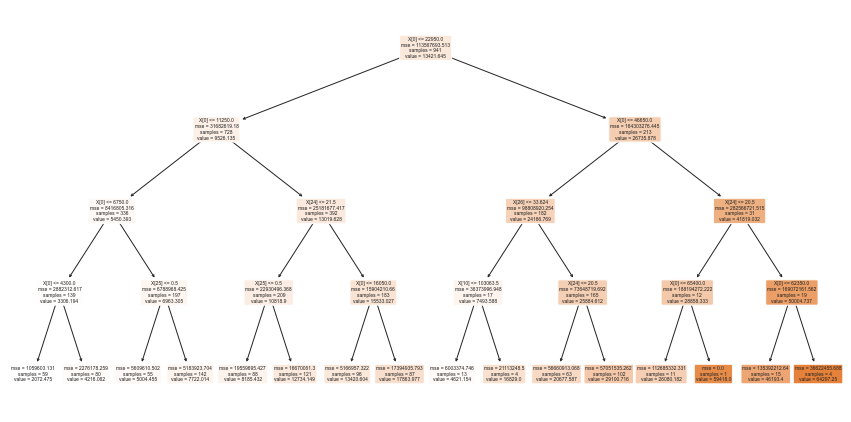

In [54]:
plt.figure(figsize=(15,7.5))
plot_tree(amt_m01_Tree, filled=True,
         rounded=True)

In [55]:
default_pct_loan_m_debtinc = round((df[TARGET_A][(df["M_DEBTINC"] == 1) & (df[TARGET_F] == 1) ].sum()) / (
    df["LOAN"][(df["M_DEBTINC"] == 1) & (df[TARGET_F] == 1)].sum()),2)

default_pct_loan_wo_m_debtinc = round((df[TARGET_A][(df["M_DEBTINC"] == 0) & (df[TARGET_F] == 1) ].sum()) / (
    df["LOAN"][(df["M_DEBTINC"] == 1) & (df[TARGET_F] == 0)].sum()),2)

print("Default % of Loan when missing debtinc =", default_pct_loan_m_debtinc)
print("Default % of Loan without missing debtinc =", default_pct_loan_wo_m_debtinc)

Default % of Loan when missing debtinc = 0.91
Default % of Loan without missing debtinc = 0.56


***
The decision tree makes sense given that the starting point is the size of the loan. Something interesting to note is the size of the default relative to the loan when the 'DEBTINC' is missing compared to not missing. The default total in aggregate goes from 91% of loan amount to 56% depending on the whether or not this field is missing. This would be something worth looking into more. Outside of size of loan, the other critical variables in the decision tree line up with what was seen in the decision tree flagging for loan default
***

## Random Forests
### Random Forest Predict Probability of Loan Default

In [56]:
# Model 
fm01_RF = RandomForestClassifier(n_estimators=100, random_state=2)
fm01_RF = fm01_RF.fit(X_train, Y_train[TARGET_F])

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("\n===========\n")
print("RANDOM FOREST\n")
print("Probability of default")
print("Accuracy Train:", metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:", metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
print("\n")



RANDOM FOREST

Probability of default
Accuracy Train: 1.0
Accuracy Test: 0.9194630872483222




In [57]:
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1] 
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

In [58]:
fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

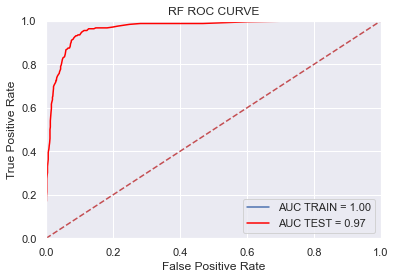

In [59]:
# Plot ROC Curve

plt.title("RF ROC CURVE")
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color = "red")
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [60]:
# variable selection
rf_vars_default_prob = getEnsembleTreeVars(fm01_RF, feature_cols)
print(rf_vars_default_prob)

[('M_DEBTINC', 100), ('IMP_DEBTINC', 66), ('IMP_CLAGE', 42), ('IMP_DELINQ', 41), ('IMP_VALUE', 36), ('LOAN', 35), ('IMP_MORTDUE', 34), ('IMP_CLNO', 31), ('IMP_YOJ', 27), ('IMP_DEROG', 21)]


### Random Forest Predict Loan Default Loss Amount

In [61]:
# Model 
amt_m01_RF = RandomForestRegressor(n_estimators = 100, random_state=1)
amt_m01_RF = amt_m01_RF.fit( W_train, Z_train[TARGET_A])

Z_Pred_train = amt_m01_RF.predict(W_train)
Z_Pred_test = amt_m01_RF.predict(W_test)

RMSE_TRAIN = math.sqrt( metrics.mean_squared_error(Z_train[TARGET_A], Z_Pred_train))
RMSE_TEST = math.sqrt( metrics.mean_squared_error(Z_test[TARGET_A], Z_Pred_test))

print("RF RMSE Train:", RMSE_TRAIN)
print("RF RMSE Test:", RMSE_TEST)
RMSE_RF = RMSE_TEST

RF RMSE Train: 1214.6039598071782
RF RMSE Test: 3276.139776266803


In [62]:
# Variable Selection
rf_vars_loss_amt = getEnsembleTreeVars(amt_m01_RF, feature_cols)
print(rf_vars_loss_amt)

[('LOAN', 100), ('IMP_CLNO', 12), ('IMP_DEBTINC', 5)]


## Gradient Boosting
### Gradient Boosting Predict Probability of Loss Default

In [63]:
fm01_GB = GradientBoostingClassifier( random_state = 1)
fm01_GB = fm01_GB.fit( X_train, Y_train[ TARGET_F ])

Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

print("\n=========\n")
print("GRADIENT BOOSTING\n")
print("Probability of default")
print("Accuracy Train:", metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:", metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
print("\n")



GRADIENT BOOSTING

Probability of default
Accuracy Train: 0.9236577181208053
Accuracy Test: 0.9068791946308725




In [64]:
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

In [65]:
fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test

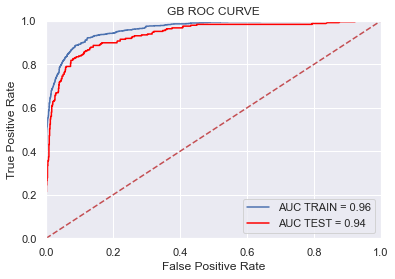

In [66]:
# Plot ROC Curve

plt.title('GB ROC CURVE')
plt.plot(fpr_train, tpr_train, 'b', label = 'AUC TRAIN = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC TEST = %0.2f' % roc_auc_test, color='red')
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [67]:
gb_vars_default_prob = getEnsembleTreeVars(fm01_GB, feature_cols)
print(gb_vars_default_prob)

[('M_DEBTINC', 100), ('IMP_DEBTINC', 29), ('IMP_DELINQ', 19), ('IMP_CLAGE', 14)]


## Gradient Boosting Predict Loan Default Loss Amount

In [68]:
amt_m01_GB = GradientBoostingRegressor(random_state = 1)
amt_m01_GB = amt_m01_GB.fit(W_train, Z_train[TARGET_A])

Z_Pred_train = amt_m01_GB.predict(W_train)
Z_Pred_test = amt_m01_GB.predict(W_test)

RMSE_TRAIN = math.sqrt(metrics.mean_squared_error(Z_train[TARGET_A], Z_Pred_train))
RMSE_TEST = math.sqrt(metrics.mean_squared_error(Z_test[TARGET_A], Z_Pred_test))

print("GB RMSE TRAIN:", RMSE_TRAIN)
print("GB_RMSE_TEST:", RMSE_TEST)

RMSE_GB = RMSE_TEST

GB RMSE TRAIN: 1242.0164630154807
GB_RMSE_TEST: 2557.4999187687126


In [69]:
# Variable Selection
gb_vars_loss_amt = getEnsembleTreeVars(amt_m01_GB, feature_cols)
print(gb_vars_loss_amt)

[('LOAN', 100), ('IMP_CLNO', 14), ('IMP_DEBTINC', 5), ('M_DEBTINC', 5)]


## Cost Complexity Pruning for Decision Tree

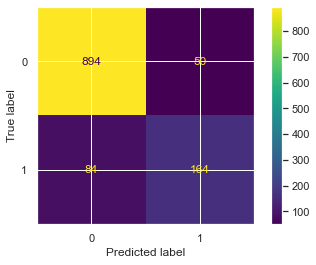

In [70]:
# confusion matrix
plot_confusion_matrix(fm01_Tree, X_test, Y_test[TARGET_F])

In [71]:
# cost pruning
path = fm01_Tree.cost_complexity_pruning_path(X_train, Y_train[TARGET_F]) # determine values for alpha
ccp_alphas = path.ccp_alphas # extract different values for alpha
ccp_alphas = ccp_alphas[:-1] # exclude the maximum value for alpha

fm01_Tree_dts = [] # create an array that we will put decision trees into

## now create one decision tree per value for alpha and store it in the array
for ccp_alpha in ccp_alphas:
    fm01_Tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    fm01_Tree.fit(X_train, Y_train[TARGET_F])
    fm01_Tree_dts.append(fm01_Tree)

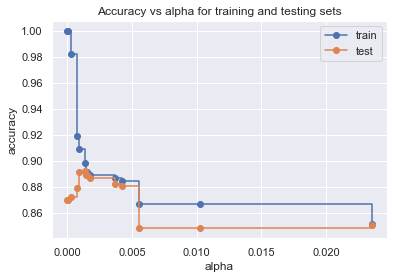

In [72]:
train_scores = [fm01_Tree.score(X_train, Y_train[TARGET_F]) for fm01_Tree in fm01_Tree_dts]
test_scores = [fm01_Tree.score(X_test, Y_test[TARGET_F]) for fm01_Tree in fm01_Tree_dts]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test", drawstyle="steps-post")
ax.legend()
plt.show()

<AxesSubplot:xlabel='tree'>

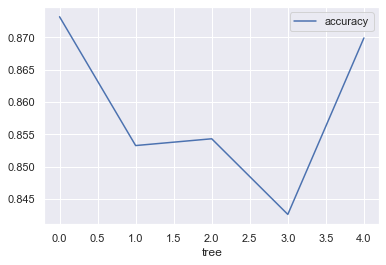

In [73]:
# cross validation for cost pruning
scores = cross_val_score(fm01_Tree, X_train, Y_train[TARGET_F], cv=5)

cv_df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})
cv_df.plot(x='tree', y='accuracy')

# different training and testing data resulted in different accuracies, alpha sensitive to datasets

<AxesSubplot:xlabel='alpha'>

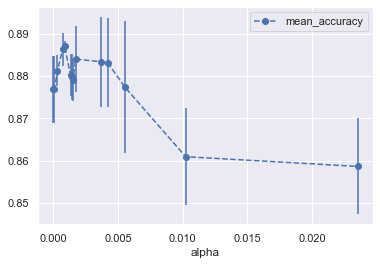

In [74]:
# use cross validation to find optimal value for alpha
alpha_loop_values = []

for ccp_alpha in ccp_alphas:
    fm01_Tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(fm01_Tree, X_train, Y_train[TARGET_F], cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])
    

alpha_results = pd.DataFrame(alpha_loop_values, 
                            columns=['alpha', 'mean_accuracy', 'std'])

alpha_results.plot(x='alpha',
                  y='mean_accuracy',
                  yerr = 'std',
                  marker='o',
                  linestyle='--')

In [75]:
alpha_results[(alpha_results['alpha'] > .0008)
              &
              (alpha_results['alpha'] < .001)]

,alpha,mean_accuracy,std
4,0.000859,0.887165,0.001043


In [76]:
ideal_ccp_alpha = alpha_results[(alpha_results['alpha'] > .0008)
              &
              (alpha_results['alpha'] < .001)]['alpha']
ideal_ccp_alpha = float(ideal_ccp_alpha)

In [77]:
fm01_Tree = tree.DecisionTreeClassifier( random_state=1, 
                                       ccp_alpha = ideal_ccp_alpha)
fm01_Tree = fm01_Tree.fit( X_train, Y_train[ TARGET_F ])

Y_Pred_train = fm01_Tree.predict(X_train)
Y_Pred_test = fm01_Tree.predict(X_test)

print("\n=============\n")
print("DECISION TREE\n")
print("Probability of default")
print("Accuracy Train:",metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:",metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
print("\n")



DECISION TREE

Probability of default
Accuracy Train: 0.9091862416107382
Accuracy Test: 0.8917785234899329




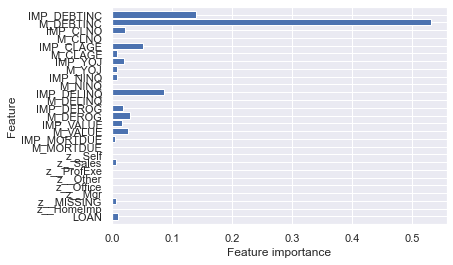

In [78]:
# decision tree feature importance
def plot_feature_importances_cancer(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(fm01_Tree)

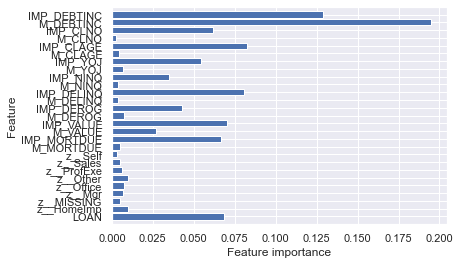

In [79]:
plot_feature_importances_cancer(fm01_RF)

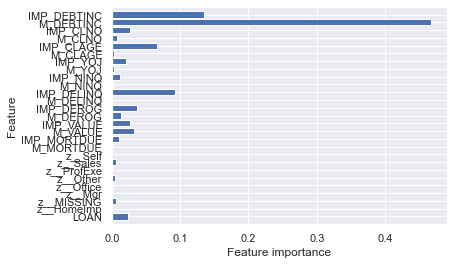

In [80]:
plot_feature_importances_cancer(fm01_GB)

## Tuning Hyperparameters for Random Forest and Gradient Boosting

In [81]:
rf = RandomForestClassifier(n_jobs = - 1, random_state=1)
params = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}
cv = GridSearchCV(rf, params, cv=5, n_jobs = -1)

cv.fit(X_train, Y_train[TARGET_F])

cv.best_params_

{'max_depth': None, 'n_estimators': 50}

In [82]:
# Model 
fm01_RF = RandomForestClassifier(n_estimators=50, random_state=1, max_depth=None)
fm01_RF = fm01_RF.fit(X_train, Y_train[TARGET_F])

Y_Pred_train = fm01_RF.predict(X_train)
Y_Pred_test = fm01_RF.predict(X_test)

print("\n===========\n")
print("RANDOM FOREST\n")
print("Probability of default")
print("Accuracy Train:", metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:", metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
print("\n")



RANDOM FOREST

Probability of default
Accuracy Train: 1.0
Accuracy Test: 0.9110738255033557




In [83]:
probs = fm01_RF.predict_proba(X_train)
p1 = probs[:,1] 
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_RF.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve(Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_RF = fpr_test
tpr_RF = tpr_test
auc_RF = roc_auc_test

print(auc_RF)

0.9620352651722253


In [84]:
gb = GradientBoostingClassifier(random_state=1)
params = {
    'n_estimators': [5,50,250,500],
    'max_depth': [1,3,5,7,9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}
cv = GridSearchCV(gb, params, cv=5, n_jobs = -1)

cv.fit(X_train, Y_train[TARGET_F])
cv.best_params_

{'learning_rate': 1, 'max_depth': 7, 'n_estimators': 250}

In [85]:
# Model
fm01_GB = GradientBoostingClassifier( random_state = 1, learning_rate = 1, max_depth=7, n_estimators=250)
fm01_GB = fm01_GB.fit( X_train, Y_train[ TARGET_F ])

Y_Pred_train = fm01_GB.predict(X_train)
Y_Pred_test = fm01_GB.predict(X_test)

print("\n=========\n")
print("GRADIENT BOOSTING\n")
print("Probability of default")
print("Accuracy Train:", metrics.accuracy_score(Y_train[TARGET_F], Y_Pred_train))
print("Accuracy Test:", metrics.accuracy_score(Y_test[TARGET_F], Y_Pred_test))
print("\n")



GRADIENT BOOSTING

Probability of default
Accuracy Train: 1.0
Accuracy Test: 0.9261744966442953




In [86]:
probs = fm01_GB.predict_proba(X_train)
p1 = probs[:,1]
fpr_train, tpr_train, threshold = metrics.roc_curve( Y_train[TARGET_F], p1)
roc_auc_train = metrics.auc(fpr_train, tpr_train)

probs = fm01_GB.predict_proba(X_test)
p1 = probs[:,1]
fpr_test, tpr_test, threshold = metrics.roc_curve( Y_test[TARGET_F], p1)
roc_auc_test = metrics.auc(fpr_test, tpr_test)

fpr_GB = fpr_test
tpr_GB = tpr_test
auc_GB = roc_auc_test
print(auc_GB)

0.9672870250136686


## ROC Curve

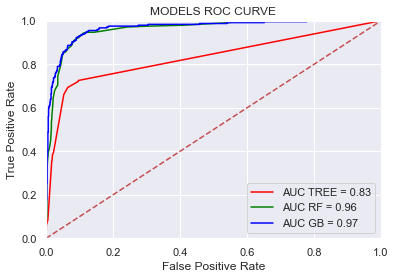

Root Mean Square Average for Defaulted Loans
TREE 5640.984056419067
RF 3276.139776266803
GB 2557.4999187687126

Area under curve Tree
0.8315293534718425
0.9620352651722253
0.9672870250136686


In [87]:
plt.title('MODELS ROC CURVE')
plt.plot(fpr_tree, tpr_tree, 'b', label = 'AUC TREE = %0.2f' % auc_tree, color="red")
plt.plot(fpr_RF, tpr_RF, 'b', label = 'AUC RF = %0.2f' % auc_RF, color="green")
plt.plot(fpr_GB, tpr_GB, 'b', label = 'AUC GB = %0.2f' % auc_GB, color="blue")
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print("Root Mean Square Average for Defaulted Loans")
print("TREE", RMSE_TREE)
print("RF", RMSE_RF)
print("GB", RMSE_GB)

print("\nArea under curve Tree")
print(auc_tree)
print(auc_RF)
print(auc_GB)

***
I spent more time to optimize the hyperparameters for the Random Forest and Gradient Boosting models. After this was done, the Gradient Boosting model improved to have the highest final accuracy at 92.6%, compared to 91.1% for the Random Forest. Overall, both the Gradient Boosting and Random Forest models performed fairly similarly, and a vast improvement to the decision tree. I'd lean towards the Gradient Boosting model because of the higher accuracy, though the Random Forest model had a higher AUC at 96% compared to 94% for the Gradient Boosting. In this example, I'd imagine overall accuracy to be more important than optimizing errors. That being said, I'd need to speak more with an industry expert because I could be wrong on that. An additional benefit to the Gradient Boosting model is the decision variables more closely lined up to what was seen on the original decision trees, especially in terms of the number of variables. 
***